<a href="https://colab.research.google.com/github/armiro/Pneumothorax-Segmentation/blob/master/pnx_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**session-holder via page element inspection**

click on the `refresh` button every 60 seconds.

`Ctrl + shift + I` to open inspection, insert the code in the console
```
function ClickRefresh(){
    console.log("Clicked on refresh button"); 
    document.querySelector("paper-icon-button").click()
}
setInterval(ClickRefresh, 60000)
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob, cv2, gzip, gc, time

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, concatenate, Lambda
from tensorflow.keras import Model, backend as K, callbacks as cb, optimizers

In [ ]:
# load the dataset
path = '/content/drive/MyDrive/Datasets/siim_acr_pneumothorax_seg/'
img_file = gzip.GzipFile(filename=path+'training_images.npy.gz', mode='r')
%time images = np.load(file=img_file)
msk_file = gzip.GzipFile(filename=path+'training_masks_resized.npy.gz', mode='r')
%time masks = np.load(file=msk_file)
metadata = pd.read_csv(filepath_or_buffer=path+'converted-train-rle.csv', index_col=None)
age = metadata.loc[:, 'PatientAge']
sex = metadata.loc[:, 'PatientSex']
view = metadata.loc[:, 'ImageView']

print('metadata columns:', metadata.columns)
print('shape of the dataset:', images.shape)
print('shape of the masks:', masks.shape)

CPU times: user 28.1 s, sys: 1.28 s, total: 29.4 s
Wall time: 29.4 s
CPU times: user 8.92 s, sys: 615 ms, total: 9.53 s
Wall time: 9.53 s
metadata columns: Index(['ImageId', 'PatientId', 'PatientAge', 'PatientSex', 'ImageView'], dtype='object')
shape of the dataset: (12047, 512, 512)
shape of the masks: (12047, 512, 512)


In [ ]:
# preprocessing: second resize
images = np.array([cv2.resize(image, dsize=(256, 256)) for image in images]).astype('uint8')
masks = np.array([cv2.resize(mask, dsize=(256, 256)) for mask in masks]).astype('float64')
print('resized masks and images!')

# preprocessing: CLAHE
images = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in images])
print('applied CLAHE on images!')

# preprocessing: expand dimensions
images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)
print('expanded dimensions of images and masks!')

# preprocessing: train-test split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=10)
del images, masks
print('splitted dataset into training and validation sets!')

print('training images/masks shape:', X_train.shape, y_train.shape)
print('validation images/masks shape:', X_val.shape, y_val.shape)

In [ ]:
# # because of memory limit, manual data splitter is defined so that we can split 
# # images and masks in different steps and delete unnecessary variables in between
# def manual_train_test_split(data, test_ratio, init_indices):
#     if init_indices is not None:
#         shuffle_indices = init_indices
#     else:
#         shuffle_indices = np.random.RandomState(seed=23).permutation(len(data))
#     test_size = int(test_ratio * len(data))
#     test_indices = shuffle_indices[:test_size]
#     train_indices = shuffle_indices[test_size:]
#     return data[train_indices], data[test_indices], shuffle_indices


# X_train, X_val, indices = manual_train_test_split(data=images, test_ratio=0.2, init_indices=None)
# del images
# gc.collect()

# y_train, y_val, _ = manual_train_test_split(data=masks, test_ratio=0.2, init_indices=indices)
# del masks
# gc.collect()

In [ ]:
# define metrics: dice coefficient (DICE/F1-score) and intersection over union (IoU/Jaccard)
def dice_coef(y_true, y_pred, smooth=1):
    overlap = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    total_area = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dsc = K.mean((2.0 * overlap + smooth) / (total_area + smooth), axis=0)
    return dsc


def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# define custom loss as a combination of dice and bce
def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

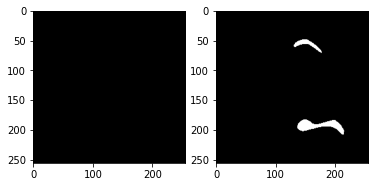

inter-dice is: tf.Tensor(0.0008237232289950577, shape=(), dtype=float64) and inter-jaccard is: tf.Tensor(0.0008237232289950577, shape=(), dtype=float64)
self-dice is: tf.Tensor(1.0, shape=(), dtype=float64) and self-jaccard is: tf.Tensor(1.0, shape=(), dtype=float64)


In [ ]:
# test masks to see if both DSC ans IoU metrics are working correctly
im1 = np.expand_dims(y_train[22], axis=0)
im2 = np.expand_dims(y_train[12], axis=0)

plt.subplot(1, 2, 1)
plt.imshow(X=np.squeeze(im1, axis=(0, -1)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(X=np.squeeze(im2, axis=(0, -1)), cmap='gray')
plt.show()

print('inter-dice is:', dice_coef(im1, im2), 'and inter-jaccard is:', iou_coef(im1, im2))
print('self-dice is:', dice_coef(im1, im1), 'and self-jaccard is:', iou_coef(im1, im1))

In [ ]:
# !pip install keras_lr_finder

Epoch 1/10
151/151 [==============================] - 33s 218ms/step - loss: 1.6508 - dice_coef: 0.0059 - iou_coef: 0.0031
Epoch 2/10
151/151 [==============================] - 33s 219ms/step - loss: 1.5767 - dice_coef: 0.0059 - iou_coef: 0.0031
Epoch 3/10
151/151 [==============================] - 33s 219ms/step - loss: 1.1538 - dice_coef: 0.0040 - iou_coef: 0.0022
Epoch 4/10
151/151 [==============================] - 33s 219ms/step - loss: 1.0537 - dice_coef: 0.0042 - iou_coef: 0.0024
Epoch 5/10
151/151 [==============================] - 33s 219ms/step - loss: 1.0319 - dice_coef: 0.0062 - iou_coef: 0.0037
Epoch 6/10
151/151 [==============================] - 33s 219ms/step - loss: 1.0245 - dice_coef: 0.0110 - iou_coef: 0.0065
Epoch 7/10
151/151 [==============================] - 33s 219ms/step - loss: 1.0303 - dice_coef: 0.0067 - iou_coef: 0.0042
Epoch 8/10
151/151 [==============================] - 33s 219ms/step - loss: 1.0285 - dice_coef: 0.0050 - iou_coef: 0.0033
Epoch 9/10
151/1

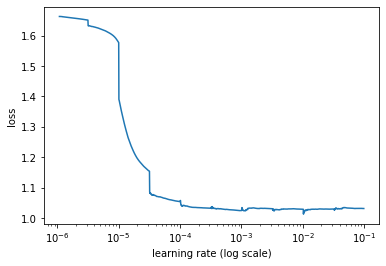

In [ ]:
# find best learning rate for adam optimizer
from keras_lr_finder.lr_finder import LRFinder

lr_finder = LRFinder(model=model)
lr_finder.find(x_train=X_train, y_train=y_train, start_lr=0.000001, 
               end_lr=0.1, batch_size=64, epochs=10)

lr_finder.plot_loss() # best lr is where the plot has highest neg slope before the loss jump

In [ ]:
# model architecture: vanilla unet
def vanilla_unet(input_size=(256,256,1), dr_ratio=0.5):
    inputs = Input(input_size)
    ds_inputs = Lambda(lambda image: image/255.0, name='down_scaler')(inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(ds_inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Dropout(rate=dr_ratio)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Dropout(rate=dr_ratio)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
 
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Dropout(rate=dr_ratio)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
 
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Dropout(rate=dr_ratio)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(rate=dr_ratio)(conv5)
 
    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Dropout(rate=dr_ratio)(conv6)
 
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(rate=dr_ratio)(conv7)
 
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(rate=dr_ratio)(conv8)
 
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Dropout(rate=dr_ratio)(conv9)
 
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
    return Model(inputs=[inputs], outputs=[conv10], name='unet_with_dropout')


model = vanilla_unet()
customAdam = optimizers.Adam(learning_rate=0.00002)
model.compile(optimizer=customAdam, loss=bce_dice_loss, metrics=[dice_coef, iou_coef])
model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# define image augmentation function using keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

img_aug = ImageDataGenerator(rotation_range=20, horizontal_flip=True, vertical_flip=False, 
                             zoom_range=[0.9, 1.1], brightness_range=[0.9, 1.1], rescale=None,
                             width_shift_range=0.1, height_shift_range=0.1, fill_mode='constant', 
                             zca_whitening=False, dtype='uint8')

In [ ]:
# OOP-based batch loader with shuffling option
class BatchLoader():
    def __init__(self, x_train, y_train, batch_size):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.indices = np.arange(len(x_train))
        self.counter = 0
    
    def get_next(self):
        x_batch = list()
        y_batch = list()
        # select indexed samples from images and masks
        start = self.counter * self.batch_size
        for i in range(self.batch_size):
            x_batch.append(self.x_train[self.indices[start+i]])
            y_batch.append(self.y_train[self.indices[start+i]])
        self.counter += 1
        # apply image augmentation on both images and masks
        rnd_seed = np.random.randint(400)
        gen_img = img_aug.flow(np.array(x_batch), batch_size=self.batch_size, shuffle=False, seed=rnd_seed)
        gen_msk = img_aug.flow(np.array(y_batch), batch_size=self.batch_size, shuffle=False, seed=rnd_seed)
        x_batch.clear()
        y_batch.clear()
        x_batch = gen_img.next().astype('uint8')
        y_batch = gen_msk.next()
        y_batch = [np.where(mask > 0, 1.0, 0.0) for mask in y_batch] # disable brightness adj. effect on masks
        return np.array(x_batch), np.array(y_batch)
    
    def shuffle(self):
        np.random.shuffle(self.indices)
        print('shuffled batch indices')

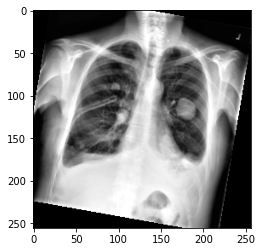

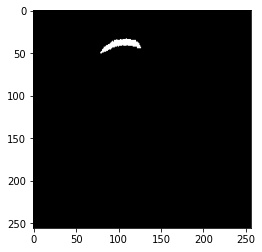

255 1.0
<class 'numpy.uint8'>


In [ ]:
# test to see if data augmentation is working correctly for the masks
btl = BatchLoader(X_train, y_train, batch_size=1)
# btl.shuffle()
xt, yt = btl.get_next()
plt.imshow(np.squeeze(xt, axis=(0, -1)), cmap='gray')
plt.show()
plt.imshow(np.squeeze(yt, axis=(0, -1)), cmap='gray')
plt.show()
print(np.max(xt), np.max(yt))
print(type(xt[0][0][0][0]))

In [ ]:
# define training callbacks to use via fit/fit_generator only
# checkpoint = cb.ModelCheckpoint('/content/drive/My Drive/pnx_model/eps={epoch:03d}_valLoss={val_loss:.4f}.hdf5',
#                                 monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
early_stopping = cb.EarlyStopping(monitor='val_loss', patience=10, mode='auto', verbose=1, 
                                  min_delta=0.0001)
cb_list = [early_stopping]


# model.load_weights('/content/drive/MyDrive/pnx_model/eps=xxx_valLoss=0.xxxx.hdf5')

In [ ]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model", monitor='dice_coef', 
                                      mode='max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [ ]:
training = model.fit(x=X_train, y=y_train, batch_size=64, epochs=100, verbose=1,
                     steps_per_epoch=len(X_train)//64.0, validation_data=(X_val, y_val),
                     callbacks=cb_list)

fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(training.history['loss'], color='r', label='training_loss')
plt.plot(training.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(training.history['dice_coef'], color='r', label='training_dsc')
plt.plot(training.history['val_dice_coef'], color='g', label='validation_dsc')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(training.history['iou_coef'], color='r', label='training_iou')
plt.plot(training.history['val_iou_coef'], color='g', label='validation_iou')
plt.legend()
plt.show()
# fig.savefig('/content/drive/My Drive/pnx_model/training_bestlr_dr0.5.png', bbox_inches='tight')

In [ ]:
# load model weights from no-aug pretrained model and then train for few epochs with aug
num_epochs = 120
current_epoch = 101
step_epoch = len(X_train) // 64.0
num_iter = 0
batch_loader = BatchLoader(x_train=X_train, y_train=y_train, batch_size=64)
# model.load_weights(filepath='/content/drive/MyDrive/pnx_model/unet_eps=100_dsc=0.60_valdsc=0.33.hdf5')

while current_epoch < num_epochs:
    t0 = time.time()
    while num_iter < step_epoch:
        xb, yb = batch_loader.get_next()
        model.train_on_batch(xb, yb)
        num_iter += 1
    batch_loader.shuffle()
    batch_loader.counter = 0
    print('epoch:', current_epoch, '| elapsed time:', round((time.time()-t0)/60.0, 2), 'mins')
    print('performance over TRAINING set:')
    model.evaluate(x=X_train, y=y_train, verbose=2)
    print('performance over VALIDATION set:')
    model.evaluate(x=X_val, y=y_val, verbose=2)
    current_epoch += 1
    num_iter = 0
print('training finished!')


print('final model eval on training set:')
model.evaluate(x=X_train, y=y_train, verbose=1)
print('final model eval on validation set:')
model.evaluate(x=X_val, y=y_val, verbose=1)

model.save('/content/drive/MyDrive/pnx_model/unet_with_aug.hdf5')

In [ ]:
# model.save('/content/drive/MyDrive/pnx_model/unet_eps=38_dsc=0.78_valdsc=0.78.hdf5')
# model.load_weights('/content/drive/MyDrive/pnx_model/unet_eps=100_dsc=0.60_valdsc=0.33.hdf5')

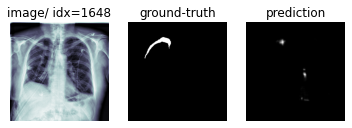

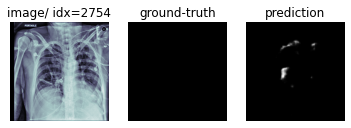

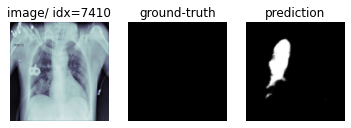

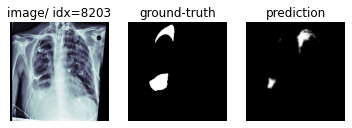

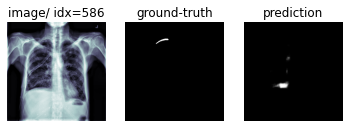

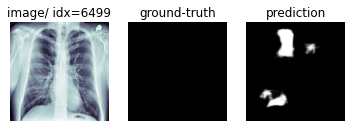

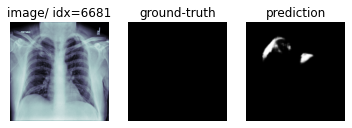

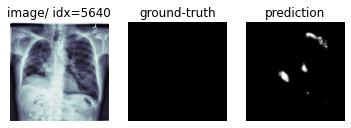

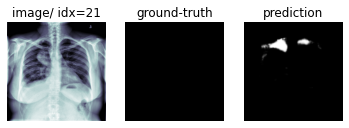

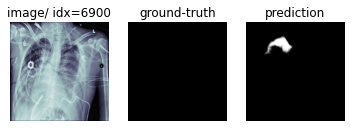

In [ ]:
for _ in range(10):
    idx = np.random.randint(0, len(X_train))
    fig = plt.figure(num=3, figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.title('image/ idx=%d' % idx)
    plt.imshow(X=X_train[idx].squeeze(), cmap='bone')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('ground-truth')
    plt.imshow(X=y_train[idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('prediction')
    pred = model.predict(np.expand_dims(X_train[idx], axis=0))
    plt.imshow(X=np.squeeze(pred, axis=(0, -1)), cmap='gray')
    plt.axis('off')
    plt.show()
    # fig.savefig('/content/drive/MyDrive/unet_v1_XX.png', bbox_inches='tight')

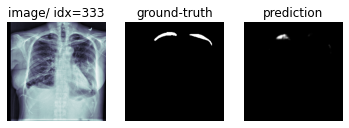

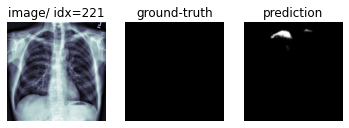

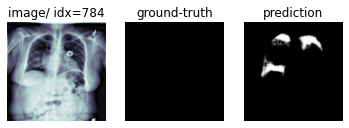

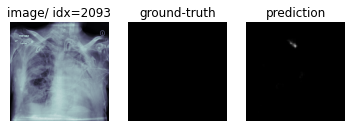

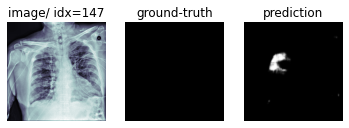

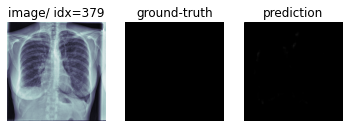

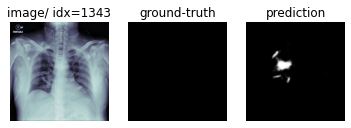

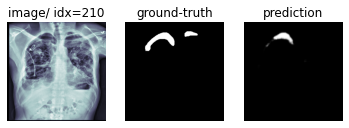

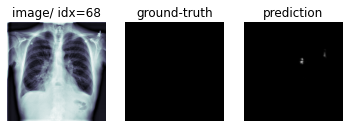

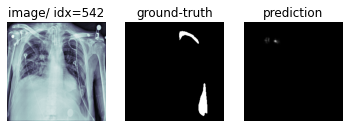

In [ ]:
for i in range(10):
    idx = np.random.randint(0, len(X_val))
    fig = plt.figure(num=3, figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.title('image/ idx=%d' % idx)
    plt.imshow(X=X_val[idx].squeeze(), cmap='bone')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('ground-truth')
    plt.imshow(X=y_val[idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('prediction')
    pred = model.predict(np.expand_dims(X_val[idx], axis=0))
    plt.imshow(X=np.squeeze(pred, axis=(0, -1)), cmap='gray')
    plt.axis('off')
    plt.show()
    # fig.savefig('/content/drive/MyDrive/unet_v1_XX.png', bbox_inches='tight')